In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from datetime import date, time, timedelta
from datetime import datetime as dt

import requests
from bs4 import BeautifulSoup as bs
from random import randint
from time import sleep
import time, os
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import glob
from urllib.request import urlopen

import PIL
from PIL import Image
from skimage.io import imread, imshow


import os, shutil
from dotenv import load_dotenv
import time
from collections import Counter
import random
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image as IMG

# pip install scikit-image

2022-08-07 20:38:25.144560: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-07 20:38:25.144597: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Code-Structure and transfer-learning input models were inspired by the notebook mentioned in first office hours:
https://github.com/PurpleGrace/Deep_Learning_Tools_Image_Classification/tree/main/code

# Get articles of publishers' main homepage published 02/2022-07/2022

In [2]:
df_all_publishers = pd.read_csv('project/powerbi_input_det.csv', sep=';', error_bad_lines=False)

df_all_publishers['website'].unique()

/tmp/ipykernel_21039/3133500009.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df_all_publishers = pd.read_csv('project/powerbi_input_det.csv', sep=';', error_bad_lines=False)
/tmp/ipykernel_21039/3133500009.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all_publishers = pd.read_csv('project/powerbi_input_det.csv', sep=';', error_bad_lines=False)


array(['faz.net', 'Spiegel Online', 'Sueddeutsche Zeitung', 'Zeit Online'],
      dtype=object)

Create main dataframes for each publisher

In [3]:
df_faz = df_all_publishers[df_all_publishers['website'] == 'faz.net']
df_spiegel = df_all_publishers[df_all_publishers['website'] == 'Spiegel Online']
df_sz = df_all_publishers[df_all_publishers['website'] == 'Sueddeutsche Zeitung']
df_zeit = df_all_publishers[df_all_publishers['website'] == 'Zeit Online']

df_faz = df_faz[['url', 'title', 'teaser', 'ressort', 'article_id', 'containsflag_plus']]
df_spiegel = df_spiegel[['url', 'title', 'teaser', 'ressort', 'article_id', 'containsflag_plus']]
df_sz = df_sz[['url', 'title', 'teaser', 'ressort', 'article_id', 'containsflag_plus']]
df_zeit = df_zeit[['url', 'title', 'teaser', 'ressort', 'article_id', 'containsflag_plus']]

df_sz = df_sz[~pd.isna(df_sz['article_id'])]
df_sz = df_sz[df_sz['article_id'].str.startswith('1.')]

df_faz = df_faz[df_faz['article_id'].str.startswith('1')]
df_faz = df_faz[~df_faz['url'].str.contains('agenturmeldungen/')]

df_faz.drop_duplicates(inplace=True)
df_spiegel.drop_duplicates(inplace=True)
df_sz.drop_duplicates(inplace=True)
df_zeit.drop_duplicates(inplace=True)

df_faz.reset_index(drop=True,inplace=True)
df_spiegel.reset_index(drop=True,inplace=True)
df_sz.reset_index(drop=True,inplace=True)
df_zeit.reset_index(drop=True,inplace=True)

In [4]:
df_sz

,url,title,teaser,ressort,article_id,containsflag_plus
0,https://www.sueddeutsche.de/meinung/gas-russla...,b'Gas aus Russland: Es war nicht nur Schr\xc3\...,b'Die deutsche Abh\xc3\xa4ngigkeit vom russisc...,meinung,1.5544172,yes
1,https://www.sueddeutsche.de/politik/krieg-in-d...,b'Gas und \xc3\x96l aus Russland: Importstopp ...,b'Ein Verzicht auf russische Energieimporte w\...,politik,1.5481016,no
2,https://www.sueddeutsche.de/politik/krieg-ukra...,b'Krieg in der Ukraine: Tschernobyl hat keinen...,b'Das ehemalige Atomkraftwerk in Tschernobyl i...,politik,1.5541547,dynamic
3,https://www.sueddeutsche.de/politik/ukraine-ru...,b'Krieg in der Ukraine: Russischer General Vit...,b'Der ukrainische Milit\xc3\xa4rgeheimdienst m...,politik,1.5543625,dynamic
4,https://www.sueddeutsche.de/kultur/corona-krie...,b'Krieg und Corona: Putin hat gewonnen',b'Seit dem Einmarsch in die Ukraine scheint Co...,kultur,1.5544033,yes
...,...,...,...,...,...,...
13804,https://www.sueddeutsche.de/muenchen/muenchen-...,Das Münchner Start-up Kuchentratsch hat Insolv...,Bei Kuchentratsch fanden viele Omas eine Besch...,muenchen,1.5626433,dynamic
13805,https://www.sueddeutsche.de/muenchen/muenchen-...,München: Kunstakademie zeigt Jahresausstellung...,Die Studierenden der Kunstakademie haben eine ...,muenchen,1.5626352,dynamic
13806,https://www.sueddeutsche.de/bayern/atomkraft-g...,Atom-Energie in Bayern: Verschärfter Stresstes...,Die Anti-Atompartei stimmt einer Laufzeitverlä...,bayern,1.5626379,dynamic
13807,https://www.sueddeutsche.de/bayern/maskenaffae...,Bayern: Masken-Millionärin Tandler erneut in L...,Maskenaffären: Andrea Tandler soll erneut in d...,bayern,1.5626184,dynamic


Get Image URLs for each article

In [ ]:
images_faz = []

for i in range(len(df_faz['url'][:50000])):
    try:
        
        response = requests.get(df_faz['url'][i])
        page = response.text
        soup = bs(page)
        image = soup.find('article').find('img')['data-retina-src']

        images_faz.append(image)
    except:
        images_faz.append('na')
    print(i)

In [ ]:
# Create Checkpoint
# pd.Series(images_faz).to_csv('images_faz.csv')

In [5]:
images_faz = pd.read_csv('project/images_faz_38347.csv')
images_faz.drop('Unnamed: 0', axis=1, inplace=True)
images_faz.reset_index(drop=True, inplace=True)
images_faz.rename(columns={'0': 'image'}, inplace=True)

images_spiegel = pd.read_csv('project/images_spiegel_34289.csv')
images_spiegel.drop('Unnamed: 0', axis=1, inplace=True)
images_spiegel.reset_index(drop=True, inplace=True)
images_spiegel.rename(columns={'0': 'image'}, inplace=True)

images_sz = pd.read_csv('project/images_sz_13865.csv')
images_sz.drop('Unnamed: 0', axis=1, inplace=True)
images_sz.reset_index(drop=True, inplace=True)
images_sz.rename(columns={'0': 'image'}, inplace=True)

images_zeit = pd.read_csv('project/images_zeit_15899.csv')
images_zeit.drop('Unnamed: 0', axis=1, inplace=True)
images_zeit.reset_index(drop=True, inplace=True)
images_zeit.rename(columns={'0': 'image'}, inplace=True)

In [6]:
df_faz

,url,title,teaser,ressort,article_id,containsflag_plus
0,https://www.faz.net/aktuell/wirtschaft/sanktio...,Sanktionen im Ukraine-Krieg: Russland geht es ...,\t\t\t\tDas dritte Sanktionspaket erschwert Za...,wirtschaft,17838452,no
1,https://www.faz.net/aktuell/politik/ausland/uk...,Ukraine-Liveblog: Putin versetzt Atomstreitkrä...,Selenskyj skeptisch angesichts geplanter Verha...,politik,17804564,no
2,https://www.faz.net/aktuell/feuilleton/kehrtwe...,Neue Haltung der Regierung: Kehrtwendeland,"Dafür, dass gegenüber Diktaturen nicht nur Sac...",feuilleton,17838080,no
3,https://www.faz.net/aktuell/politik/inland/sch...,na,"Die SPD glaubt, sich ausreichend von Gerhard S...",politik,17838533,yes
4,https://www.faz.net/aktuell/wirtschaft/sanktio...,Sanktionen im Ukraine-Krieg: Russland droht de...,Die Ukraine hat sich die Sanktionen gegen Russ...,wirtschaft,17838349,yes
...,...,...,...,...,...,...
38127,https://www.faz.net/aktuell/rhein-main/frankfu...,Abwahl des Oberbürgermeisters: Vorstoß für übe...,Der Frankfurter Oberbürgermeister zieht sich n...,rhein-main,18192087,yes
38128,https://www.faz.net/aktuell/rhein-main/skyline...,Skyline-Blick: Züge fallen wegen Personalmange...,Kind geschüttelt: Haft für Vater +++ „Nicht zu...,rhein-main,18137245,no
38129,https://www.faz.net/aktuell/rhein-main/region-...,Gasknappheit: Krisenstab wegen Gas eingerichtet,Die Hessische Landesregierung trifft Vorkehrun...,rhein-main,18193256,no
38130,https://www.faz.net/aktuell/technik-motor/moto...,Ssangyong Korando E-Motion: Lädt sich Zeit,"class=""tsr-Base_Content"">\n ...",technik-motor,18180143,yes


Merge Image URLs with main dataframes

In [7]:
df_faz = pd.concat([df_faz, images_faz[:38132]], axis=1)
df_spiegel = pd.concat([df_spiegel, images_spiegel[:34078]], axis=1)
df_sz = pd.concat([df_sz, images_sz[:13809]], axis=1)
df_zeit = pd.concat([df_zeit, images_zeit[:15791]], axis=1)

In [8]:
df_zeit.iloc[5000,1]

'Boris Becker: Bum bum macht mein Herz'

In [9]:
df_zeit.iloc[5000,6]

'https://img.zeit.de/2022/15/boris-becker-tennis-wimbledon-insolvenz-teaserbild/wide__1300x731'

In [10]:
len(df_zeit.iloc[:, 6].drop_duplicates())

7056

In [11]:
df_sz.iloc[4999,1]

'Ausgetretene Farbmischung bei Tesla ist schwach wassergefährdend'

In [12]:
df_sz.iloc[4999,6]

'https://www.sueddeutsche.de/image/sz.1.5571791/1200x675?v=1650805975'

In [13]:
len(df_sz.iloc[:, 6].drop_duplicates())

10682

In [14]:
df_spiegel.iloc[34001,1]

'Energiekrise und Inflation statt Corona: Wie Rechtsextremisten ihre Anhänger für einen deutschen Wutwinter mobilisieren'

In [15]:
df_spiegel.iloc[34001,6]

'https://cdn.prod.www.spiegel.de/images/5202329f-c202-44db-a40c-e29cd57ee869_w1280_r1.77_fpx55_fpy71.jpg'

In [16]:
df_faz.iloc[38101,1]

'Volkswagen im Umbruch: Diess hört auf – Porsche-Chef Blume wird neuer VW-Lenker'

In [17]:
df_faz.iloc[38101,6]

'https://media0.faz.net/ppmedia/aktuell/wirtschaft/914531350/1.8193522/format_top1_breit/oliver-blume-der.jpg'

In [18]:
len(df_faz.iloc[:, 6].drop_duplicates())

15375

Remove duplicates from image columns

In [19]:
df_zeit_images = df_zeit.drop_duplicates(subset=['image'])
df_sz_images = df_sz.drop_duplicates(subset=['image'])
df_faz_images = df_faz.drop_duplicates(subset=['image'])
df_spiegel_images = df_spiegel.drop_duplicates(subset=['image'])

df_zeit_images = df_zeit_images.loc[df_zeit_images['image'] != 'na', :]
df_sz_images = df_sz_images.loc[df_sz_images['image'] != 'na', :]
df_faz_images = df_faz_images.loc[df_faz_images['image'] != 'na', :]
df_spiegel_images = df_spiegel_images.loc[df_spiegel_images['image'] != 'na', :]

df_zeit_images['publisher'] = 'zeit'
df_sz_images['publisher'] = 'sz'
df_spiegel_images['publisher'] = 'spiegel'
df_faz_images['publisher'] = 'faz'

df_zeit_images.reset_index(drop=True,inplace=True)
df_sz_images.reset_index(drop=True,inplace=True)
df_faz_images.reset_index(drop=True,inplace=True)
df_spiegel_images.reset_index(drop=True,inplace=True)

In [20]:
len(df_faz_images)

15374

Collect and save unique images

In [ ]:
x = 0
for img in range(len(df_faz_images['image'])):
    file_name = 'faz_'+str(img)+'_'+df_faz_images['ressort'][img]
    print(f"This is the file name: {file_name}")
    # Now let's send a request to the image URL:
    
    try:
        
        r = requests.get(df_faz_images['image'][img], stream=True)
        # We can check that the status code is 200 before doing anything else:

        if r.status_code == 200:
            # This command below will allow us to write the data to a file as binary:
            with open(file_name, 'wb') as f:
                for chunk in r:
                    f.write(chunk)
        else:
            # We will write all of the images back to the broken_images list:
            broken_images.append(df_faz_images['image'][img])
    except:
        continue
    x+=1

In [21]:
df_faz_images = df_faz_images.reset_index()
df_faz_images['index'] = df_faz_images['index'].astype('str')

df_faz_images['image_path'] = 'images_faz/faz_'+df_faz_images['index']+'_'+df_faz_images.ressort
df_faz_images.drop(['index'], inplace=True, axis=1)

In [22]:
df_faz_images.loc[df_faz_images.ressort.str.contains('htm'), :]

,url,title,teaser,ressort,article_id,containsflag_plus,image,publisher,image_path
607,https://www.faz.net/aktuell/eilmeldung-ukraine...,EILMELDUNG: Ukraine fordert sofortiges Ende vo...,"class=""tsr-Base_Content"">\n</div",eilmeldung-ukraine-fordert-sofortiges-ende-von...,17850701,no,https://media1.faz.net/ppmedia/aktuell/politik...,faz,images_faz/faz_607_eilmeldung-ukraine-fordert-...
836,https://www.faz.net/aktuell/rheinmetall-co-sin...,Rheinmetall & Co.: Sind Rüstungsaktien jetzt n...,Rüstungsunternehmen können mit ihren Produkten...,rheinmetall-co-sind-ruestungsaktien-nachhaltig...,17852116,yes,https://media1.faz.net/ppmedia/aktuell/2395203...,faz,images_faz/faz_836_rheinmetall-co-sind-ruestun...
1124,https://www.faz.net/aktuell/koelner-verwaltung...,Kölner Verwaltungsgericht: Verfassungsschutz d...,Das Bundesamt für Verfassungsschutz darf die A...,koelner-verwaltungsgericht-verfassungsschutz-d...,17862544,no,https://media0.faz.net/ppmedia/aktuell/politik...,faz,images_faz/faz_1124_koelner-verwaltungsgericht...
1795,https://www.faz.net/aktuell/handelsverband-deu...,Handelsverband warnt: Kein Sonnenblumenöl hams...,NaN,handelsverband-deutsche-sollen-wegen-ukraine-k...,17878268,no,https://media1.faz.net/ppmedia/aktuell/3529129...,faz,images_faz/faz_1795_handelsverband-deutsche-so...
1905,https://www.faz.net/aktuell/franzoesischer-inn...,Frankreich: Innenminister: „Autonomie“ für Kor...,NaN,franzoesischer-innenminister-nach-protesten-zu...,17880746,no,https://media0.faz.net/ppmedia/aktuell/politik...,faz,images_faz/faz_1905_franzoesischer-innenminist...
1944,https://www.faz.net/aktuell/razzia-wegen-verda...,„Hawala-Banking“: Razzia wegen Verdacht der Ge...,In Hessen ist ein 43 Jahre alter Mann festgeno...,razzia-wegen-verdacht-der-geldwaesche-in-hesse...,17881359,no,https://media0.faz.net/ppmedia/aktuell/2282731...,faz,images_faz/faz_1944_razzia-wegen-verdacht-der-...
2180,https://www.faz.net/aktuell/gastgewerbe-erholt...,Umsatz steigt: Gastgewerbe erholt sich weiter,"Immer mehr Menschen gehen wieder in Kneipen, R...",gastgewerbe-erholt-sich-weiter-deutlich-178872...,17887284,no,https://media0.faz.net/ppmedia/aktuell/wirtsch...,faz,images_faz/faz_2180_gastgewerbe-erholt-sich-we...
2466,https://www.faz.net/aktuell/rheinmetall-aktie-...,Schwacher Dax: Rheinmetall-Aktie steigt auf Re...,"class=""tsr-Base_Content"">\n ...",rheinmetall-aktie-steigt-auf-rekordhoch-178939...,17893925,no,https://media1.faz.net/ppmedia/aktuell/wirtsch...,faz,images_faz/faz_2466_rheinmetall-aktie-steigt-a...
2844,https://www.faz.net/aktuell/lokaltermin-taj-ma...,Lokaltermin „Taj Mahal“: Indische Küche mit Tr...,Das Taj Mahal in Frankfurt serviert seit dreiß...,lokaltermin-taj-mahal-indische-kueche-mit-trad...,17904283,yes,https://media1.faz.net/ppmedia/aktuell/3471259...,faz,images_faz/faz_2844_lokaltermin-taj-mahal-indi...
2925,https://www.faz.net/aktuell/habeck-deutschland...,Deutsche Energieabhängigkeit: Habeck: Deutschl...,Wirtschaftsminister Robert Habeck hat angekünd...,habeck-deutschland-koennte-russische-oelimport...,17908260,no,https://media1.faz.net/ppmedia/aktuell/wirtsch...,faz,images_faz/faz_2925_habeck-deutschland-koennte...


In [23]:
df_faz_images.iloc[607,8] = 'images_faz/faz_607_politik'
df_faz_images.iloc[836,8] = 'images_faz/faz_836_wirtschaft'
df_faz_images.iloc[1124,8] = 'images_faz/faz_1124_rhein-main'
df_faz_images.iloc[1795,8] = 'images_faz/faz_1795_gesellschaft'
df_faz_images.iloc[1905,8] = 'images_faz/faz_1905_sport'
df_faz_images.iloc[1944,8] = 'images_faz/faz_1944_sport'
df_faz_images.iloc[2180,8] = 'images_faz/faz_2180_wirtschaft'
df_faz_images.iloc[2466,8] = 'images_faz/faz_2466_technik-motor'
df_faz_images.iloc[2844,8] = 'images_faz/faz_2844_sport'
df_faz_images.iloc[2925,8] = 'images_faz/faz_2925_rhein-main'
df_faz_images.iloc[2998,8] = 'images_faz/faz_2998_gesellschaft'
df_faz_images.iloc[3256,8] = 'images_faz/faz_3256_feuilleton'
df_faz_images.iloc[3331,8] = 'images_faz/faz_3331_rhein-main'
df_faz_images.iloc[3606,8] = 'images_faz/faz_3606_gesellschaft'
df_faz_images.iloc[3714,8] = 'images_faz/faz_3714_karriere-hochschule'
df_faz_images.iloc[3911,8] = 'images_faz/faz_3911_sport'
df_faz_images.iloc[4152,8] = 'images_faz/faz_4152_feuilleton'
df_faz_images.iloc[4173,8] = 'images_faz/faz_4173_faz.net'
df_faz_images.iloc[4174,8] = 'images_faz/faz_4174_wirtschaft'
df_faz_images.iloc[4583,8] = 'images_faz/faz_4583_feuilleton'
df_faz_images.iloc[4717,8] = 'images_faz/faz_4717_rhein-main'
df_faz_images.iloc[4792,8] = 'images_faz/faz_4792_feuilleton'
df_faz_images.iloc[5108,8] = 'images_faz/faz_5108_gesellschaft'
df_faz_images.iloc[5361,8] = 'images_faz/faz_5361_wirtschaft'
df_faz_images.iloc[5397,8] = 'images_faz/faz_5397_wirtschaft'
df_faz_images.iloc[5431,8] = 'images_faz/faz_5431_sport'
df_faz_images.iloc[6282,8] = 'images_faz/faz_6282_wirtschaft'
df_faz_images.iloc[6291,8] = 'images_faz/faz_6291_politik'
df_faz_images.iloc[6468,8] = 'images_faz/faz_6468_politik'
df_faz_images.iloc[6623,8] = 'images_faz/faz_6623_rhein-main'
df_faz_images.iloc[6860,8] = 'images_faz/faz_6860_rhein-main'
df_faz_images.iloc[6887,8] = 'images_faz/faz_6887_stil'
df_faz_images.iloc[6986,8] = 'images_faz/faz_6986_sport'
df_faz_images.iloc[7477,8] = 'images_faz/faz_7477_sport'
df_faz_images.iloc[7619,8] = 'images_faz/faz_7619_feuilleton'
df_faz_images.iloc[7731,8] = 'images_faz/faz_7731_feuilleton'
df_faz_images.iloc[8317,8] = 'images_faz/faz_8317_wirtschaft'
df_faz_images.iloc[8671,8] = 'images_faz/faz_8671_politik'
df_faz_images.iloc[9026,8] = 'images_faz/faz_9026_rhein-main'
df_faz_images.iloc[9610,8] = 'images_faz/faz_9610_politik'
df_faz_images.iloc[9715,8] = 'images_faz/faz_9715_wirtschaft'
df_faz_images.iloc[9784,8] = 'images_faz/faz_9784_technik-motor'
df_faz_images.iloc[9818,8] = 'images_faz/faz_9818_sport'
df_faz_images.iloc[9954,8] = 'images_faz/faz_9954_stil'
df_faz_images.iloc[10239,8] = 'images_faz/faz_10239_feuilleton'
df_faz_images.iloc[11487,8] = 'images_faz/faz_11487_wirtschaft'
df_faz_images.iloc[11941,8] = 'images_faz/faz_11941_gesellschaft'
df_faz_images.iloc[12370,8] = 'images_faz/faz_12370_rhein-main'
df_faz_images.iloc[12944,8] = 'images_faz/faz_12944_wissen'
df_faz_images.iloc[13424,8] = 'images_faz/faz_13424_rhein-main'
df_faz_images.iloc[13468,8] = 'images_faz/faz_13468_wissen'
df_faz_images.iloc[14009,8] = 'images_faz/faz_14009_gesellschaft'
df_faz_images.iloc[14047,8] = 'images_faz/faz_14047_rhein-main'
df_faz_images.iloc[15301,8] = 'images_faz/faz_15301_gesellschaft'
df_faz_images.iloc[15327,8] = 'images_faz/faz_15327_rhein-main'

In [24]:
df_faz_images.loc[df_faz_images.image_path.str.contains('htm'), :]

,url,title,teaser,ressort,article_id,containsflag_plus,image,publisher,image_path


In [25]:
df_faz_images_temp = df_faz_images.reset_index()

In [26]:
df_faz_images_temp[13:16]

,index,url,title,teaser,ressort,article_id,containsflag_plus,image,publisher,image_path
13,13,https://www.faz.net/aktuell/politik/inland/put...,Nach Putins Einmarsch: Eine gescheiterte Gener...,Der deutsche Idealismus erweist sich als histo...,politik,17834124,yes,https://media0.faz.net/ppmedia/redaktion/39466...,faz,images_faz/faz_13_politik
14,14,https://www.faz.net/aktuell/feuilleton/debatte...,"Kundgebung in Frankfurt: Seid gewarnt, Putin k...","Erschüttert, aber ungebrochen: Auf einer Kundg...",feuilleton,17838178,yes,https://media1.faz.net/ppmedia/aktuell/3409347...,faz,images_faz/faz_14_feuilleton
15,15,https://www.faz.net/aktuell/wirtschaft/100-mil...,Viel Geld für die Bundeswehr: 100 Milliarden E...,Trotz Sondervermögen für die Bundeswehr soll i...,wirtschaft,17838205,no,https://media1.faz.net/ppmedia/aktuell/gesells...,faz,images_faz/faz_15_wirtschaft


In [27]:
df_faz_images_temp.tail()

,index,url,title,teaser,ressort,article_id,containsflag_plus,image,publisher,image_path
15369,15369,https://www.faz.net/aktuell/feuilleton/medien/...,Doku zu Attentat von München: Er lockte die ju...,Die Dokumentation „22. Juli - Die Schüsse von ...,feuilleton,18189862,no,https://media1.faz.net/ppmedia/aktuell/3999768...,faz,images_faz/faz_15369_feuilleton
15370,15370,https://www.faz.net/aktuell/feuilleton/debatte...,Sprachenpolitik in Algerien: Sie könnten so po...,"class=""tsr-Base_Content"">\n ...",feuilleton,18189879,yes,https://media0.faz.net/ppmedia/aktuell/2836992...,faz,images_faz/faz_15370_feuilleton
15371,15371,https://www.faz.net/podcasts/f-a-z-podcast-fue...,F.A.Z. Podcast für Deutschland: Donald Trumps ...,Der Untersuchungsausschuss ist in seine letzte...,faz.net,18193423,no,https://media0.faz.net/ppmedia/aktuell/3621421...,faz,images_faz/faz_15371_faz.net
15372,15372,https://www.faz.net/aktuell/rhein-main/kultur/...,„Worschtmichels Traum“: Nüchternheit ist Hochv...,"class=""tsr-Base_Content"">\n ...",rhein-main,18193070,yes,https://media1.faz.net/ppmedia/aktuell/3649147...,faz,images_faz/faz_15372_rhein-main
15373,15373,https://www.faz.net/aktuell/rhein-main/region-...,Gasknappheit: Krisenstab wegen Gas eingerichtet,Die Hessische Landesregierung trifft Vorkehrun...,rhein-main,18193256,no,https://media0.faz.net/ppmedia/aktuell/3333815...,faz,images_faz/faz_15373_rhein-main


In [28]:
x = 15374
for i in range((15373-13)):
    df_faz_images_temp.iloc[(x-i-1), 0] = x-i

In [29]:
df_faz_images_temp[13:16]

,index,url,title,teaser,ressort,article_id,containsflag_plus,image,publisher,image_path
13,13,https://www.faz.net/aktuell/politik/inland/put...,Nach Putins Einmarsch: Eine gescheiterte Gener...,Der deutsche Idealismus erweist sich als histo...,politik,17834124,yes,https://media0.faz.net/ppmedia/redaktion/39466...,faz,images_faz/faz_13_politik
14,15,https://www.faz.net/aktuell/feuilleton/debatte...,"Kundgebung in Frankfurt: Seid gewarnt, Putin k...","Erschüttert, aber ungebrochen: Auf einer Kundg...",feuilleton,17838178,yes,https://media1.faz.net/ppmedia/aktuell/3409347...,faz,images_faz/faz_14_feuilleton
15,16,https://www.faz.net/aktuell/wirtschaft/100-mil...,Viel Geld für die Bundeswehr: 100 Milliarden E...,Trotz Sondervermögen für die Bundeswehr soll i...,wirtschaft,17838205,no,https://media1.faz.net/ppmedia/aktuell/gesells...,faz,images_faz/faz_15_wirtschaft


In [30]:
df_faz_images_temp.tail()

,index,url,title,teaser,ressort,article_id,containsflag_plus,image,publisher,image_path
15369,15370,https://www.faz.net/aktuell/feuilleton/medien/...,Doku zu Attentat von München: Er lockte die ju...,Die Dokumentation „22. Juli - Die Schüsse von ...,feuilleton,18189862,no,https://media1.faz.net/ppmedia/aktuell/3999768...,faz,images_faz/faz_15369_feuilleton
15370,15371,https://www.faz.net/aktuell/feuilleton/debatte...,Sprachenpolitik in Algerien: Sie könnten so po...,"class=""tsr-Base_Content"">\n ...",feuilleton,18189879,yes,https://media0.faz.net/ppmedia/aktuell/2836992...,faz,images_faz/faz_15370_feuilleton
15371,15372,https://www.faz.net/podcasts/f-a-z-podcast-fue...,F.A.Z. Podcast für Deutschland: Donald Trumps ...,Der Untersuchungsausschuss ist in seine letzte...,faz.net,18193423,no,https://media0.faz.net/ppmedia/aktuell/3621421...,faz,images_faz/faz_15371_faz.net
15372,15373,https://www.faz.net/aktuell/rhein-main/kultur/...,„Worschtmichels Traum“: Nüchternheit ist Hochv...,"class=""tsr-Base_Content"">\n ...",rhein-main,18193070,yes,https://media1.faz.net/ppmedia/aktuell/3649147...,faz,images_faz/faz_15372_rhein-main
15373,15374,https://www.faz.net/aktuell/rhein-main/region-...,Gasknappheit: Krisenstab wegen Gas eingerichtet,Die Hessische Landesregierung trifft Vorkehrun...,rhein-main,18193256,no,https://media0.faz.net/ppmedia/aktuell/3333815...,faz,images_faz/faz_15373_rhein-main


In [31]:
df_faz_images_temp['index'] = df_faz_images_temp['index'].astype('str')
df_faz_images_temp['image_path'] = 'images_faz/faz_'+df_faz_images_temp['index']+'_'+df_faz_images_temp.ressort
df_faz_images_temp.drop(['index'], inplace=True, axis=1)
df_faz_images = df_faz_images_temp

In [32]:
df_spiegel_images = df_spiegel_images.reset_index()
df_spiegel_images['index'] = df_spiegel_images['index'].astype('str')

df_spiegel_images['image_path'] = 'images_spiegel/spiegel_'+df_spiegel_images['index']+'_'+df_spiegel_images.ressort
df_spiegel_images.drop(['index'], inplace=True, axis=1)

In [33]:
df_spiegel_images_temp = df_spiegel_images.reset_index()

In [34]:
df_spiegel_images_temp[190:199]

,index,url,title,teaser,ressort,article_id,containsflag_plus,image,publisher,image_path
190,190,https://www.spiegel.de/panorama/justiz/kusel-1...,Nach Polizistenmorden bei Kusel: 1600 Hinweise...,0,panorama,306c4039-b5af-4bc7-bae5-3136f70c4260,no,https://cdn.prod.www.spiegel.de/images/853871c...,spiegel,images_spiegel/spiegel_190_panorama
191,191,https://www.spiegel.de/ausland/ukraine-russlan...,Sicherheitskrise in Osteuropa: Drei schlechte ...,0,ausland,f8c5fb7a-d732-4ad1-8d97-56d65641d99e,yes,https://cdn.prod.www.spiegel.de/images/9cafe52...,spiegel,images_spiegel/spiegel_191_ausland
192,192,https://www.spiegel.de/ausland/krise-in-osteur...,Wladimir Putin kanzelt Geheimdienstchef ab: »D...,0,ausland,4ef73610-c69f-4c9a-96a8-bf9d1d67e1aa,no,https://cdn.prod.www.spiegel.de/images/44e4e32...,spiegel,images_spiegel/spiegel_192_ausland
193,193,https://www.spiegel.de/politik/deutschland/rus...,»Putin ist ein von der Geschichte besessener P...,War die SPD zu naiv im Umgang mit Putin? Frakt...,politik,0bbc43f3-2023-472f-be29-65a53e529afc,yes,https://cdn.prod.www.spiegel.de/images/3645edc...,spiegel,images_spiegel/spiegel_193_politik
194,194,https://www.spiegel.de/sport/fussball/ukraine-...,Manchester United verzichtet auf Reise mit rus...,0,sport,66818e5e-5b51-49b6-862f-e87e8275e593,no,https://cdn.prod.www.spiegel.de/images/0bfd698...,spiegel,images_spiegel/spiegel_194_sport
195,195,https://www.spiegel.de/panorama/justiz/rheinla...,Kamera in FFP2-Maske – 134 Fahrschüler beim Be...,Prüflinge in Rheinland-Pfalz filmten die Frage...,panorama,8f66f5c6-959d-4fd9-abf7-abd46a1f3430,no,https://cdn.prod.www.spiegel.de/images/4561b6c...,spiegel,images_spiegel/spiegel_195_panorama
196,196,https://www.spiegel.de/kultur/harald-schmidt-u...,"»Vieles, was heute als Belästigung gilt, hieß ...","Zyniker, Hypochonder, Coronarebell? Hier verrä...",kultur,bc148705-e70c-4b46-85cd-04391d82a9aa,yes,https://cdn.prod.www.spiegel.de/images/6fd020d...,spiegel,images_spiegel/spiegel_196_kultur
197,197,https://www.spiegel.de/gesundheit/long-covid-u...,Wenn die Qual von vorn beginnt,"Impfungen schützen auch vor Long Covid, das ze...",gesundheit,397efb37-6947-475a-9c23-285ee97b754a,yes,https://cdn.prod.www.spiegel.de/images/9832ada...,spiegel,images_spiegel/spiegel_197_gesundheit
198,198,https://www.spiegel.de/gesundheit/kristina-hae...,»Ich wollte die Frauen nicht im Stich lassen«,Die Ampelkoalition will das Werbeverbot für Sc...,gesundheit,ad7ab123-0132-475c-af80-1a630d27226b,yes,https://cdn.prod.www.spiegel.de/images/60d230b...,spiegel,images_spiegel/spiegel_198_gesundheit


In [35]:
x = 16223
for i in range((16222-193)):
    df_spiegel_images_temp.iloc[(x-i-1), 0] = x-i

In [36]:
df_spiegel_images_temp[190:199]

,index,url,title,teaser,ressort,article_id,containsflag_plus,image,publisher,image_path
190,190,https://www.spiegel.de/panorama/justiz/kusel-1...,Nach Polizistenmorden bei Kusel: 1600 Hinweise...,0,panorama,306c4039-b5af-4bc7-bae5-3136f70c4260,no,https://cdn.prod.www.spiegel.de/images/853871c...,spiegel,images_spiegel/spiegel_190_panorama
191,191,https://www.spiegel.de/ausland/ukraine-russlan...,Sicherheitskrise in Osteuropa: Drei schlechte ...,0,ausland,f8c5fb7a-d732-4ad1-8d97-56d65641d99e,yes,https://cdn.prod.www.spiegel.de/images/9cafe52...,spiegel,images_spiegel/spiegel_191_ausland
192,192,https://www.spiegel.de/ausland/krise-in-osteur...,Wladimir Putin kanzelt Geheimdienstchef ab: »D...,0,ausland,4ef73610-c69f-4c9a-96a8-bf9d1d67e1aa,no,https://cdn.prod.www.spiegel.de/images/44e4e32...,spiegel,images_spiegel/spiegel_192_ausland
193,193,https://www.spiegel.de/politik/deutschland/rus...,»Putin ist ein von der Geschichte besessener P...,War die SPD zu naiv im Umgang mit Putin? Frakt...,politik,0bbc43f3-2023-472f-be29-65a53e529afc,yes,https://cdn.prod.www.spiegel.de/images/3645edc...,spiegel,images_spiegel/spiegel_193_politik
194,195,https://www.spiegel.de/sport/fussball/ukraine-...,Manchester United verzichtet auf Reise mit rus...,0,sport,66818e5e-5b51-49b6-862f-e87e8275e593,no,https://cdn.prod.www.spiegel.de/images/0bfd698...,spiegel,images_spiegel/spiegel_194_sport
195,196,https://www.spiegel.de/panorama/justiz/rheinla...,Kamera in FFP2-Maske – 134 Fahrschüler beim Be...,Prüflinge in Rheinland-Pfalz filmten die Frage...,panorama,8f66f5c6-959d-4fd9-abf7-abd46a1f3430,no,https://cdn.prod.www.spiegel.de/images/4561b6c...,spiegel,images_spiegel/spiegel_195_panorama
196,197,https://www.spiegel.de/kultur/harald-schmidt-u...,"»Vieles, was heute als Belästigung gilt, hieß ...","Zyniker, Hypochonder, Coronarebell? Hier verrä...",kultur,bc148705-e70c-4b46-85cd-04391d82a9aa,yes,https://cdn.prod.www.spiegel.de/images/6fd020d...,spiegel,images_spiegel/spiegel_196_kultur
197,198,https://www.spiegel.de/gesundheit/long-covid-u...,Wenn die Qual von vorn beginnt,"Impfungen schützen auch vor Long Covid, das ze...",gesundheit,397efb37-6947-475a-9c23-285ee97b754a,yes,https://cdn.prod.www.spiegel.de/images/9832ada...,spiegel,images_spiegel/spiegel_197_gesundheit
198,199,https://www.spiegel.de/gesundheit/kristina-hae...,»Ich wollte die Frauen nicht im Stich lassen«,Die Ampelkoalition will das Werbeverbot für Sc...,gesundheit,ad7ab123-0132-475c-af80-1a630d27226b,yes,https://cdn.prod.www.spiegel.de/images/60d230b...,spiegel,images_spiegel/spiegel_198_gesundheit


In [37]:
df_spiegel_images_temp['index'] = df_spiegel_images_temp['index'].astype('str')
df_spiegel_images_temp['image_path'] = 'images_spiegel/spiegel_'+df_spiegel_images_temp['index']+'_'+df_spiegel_images_temp.ressort
df_spiegel_images_temp.drop(['index'], inplace=True, axis=1)
df_spiegel_images = df_spiegel_images_temp

In [38]:
df_zeit_images = df_zeit_images.reset_index()
df_zeit_images['index'] = df_zeit_images['index'].astype('str')

df_zeit_images['image_path'] = 'images_zeit/zeit_'+df_zeit_images['index']+'_'+df_zeit_images.ressort
df_zeit_images.drop(['index'], inplace=True, axis=1)

In [39]:
df_zeit_images_temp = df_zeit_images.reset_index()

In [40]:
df_zeit_images_temp[37:42]

,index,url,title,teaser,ressort,article_id,containsflag_plus,image,publisher,image_path
37,37,https://www.zeit.de/wirtschaft/unternehmen/202...,Statistisches Bundesamt: Exporte steigen weit ...,['Fast zehn Prozent mehr als noch im Dezember ...,wirtschaft,http://xml.zeit.de/wirtschaft/unternehmen/2022...,no,https://img.zeit.de/wirtschaft/2022-02/statist...,zeit,images_zeit/zeit_37_wirtschaft
38,38,https://www.zeit.de/zett/liebe-sex/2021-09/nar...,"Narzissmus: ""Alle meine Partner saßen mindeste...","['Lange verstand Katalin nicht, dass sie ihre ...",zett,http://xml.zeit.de/zett/liebe-sex/2021-09/narz...,yes,https://img.zeit.de/zett/liebe-sex/2021-09/nar...,zeit,images_zeit/zeit_38_zett
39,39,https://www.zeit.de/zett/2022-02/oeffentliche-...,Leseraufruf: Hast du Angst vor Übergriffen in ...,['Immer wieder kommt es in öffentlichen Verkeh...,zett,http://xml.zeit.de/zett/2022-02/oeffentliche-v...,no,https://img.zeit.de/zett/2022-02/diskriminieru...,zeit,images_zeit/zeit_39_zett
40,40,https://www.zeit.de/kultur/2022-02/populaerpsy...,Feuilletonpodcast: Trauma ist für alle da,['Überall werden heute Traumata verhandelt. Se...,kultur,http://xml.zeit.de/kultur/2022-02/populaerpsyc...,no,https://img.zeit.de/kultur/2020-07/kochshows-s...,zeit,images_zeit/zeit_40_kultur
41,41,https://www.zeit.de/kultur/literatur/2022-02/r...,Ostdeutschland: Der Fascho in dir,['Gleich zwei neue Bücher erzählen von der Omn...,kultur,http://xml.zeit.de/kultur/literatur/2022-02/re...,no,https://img.zeit.de/kultur/literatur/2022-02/r...,zeit,images_zeit/zeit_41_kultur


In [41]:
df_zeit_images_temp.tail()

,index,url,title,teaser,ressort,article_id,containsflag_plus,image,publisher,image_path
7050,7050,https://www.zeit.de/politik/2022-07/ukraine-ue...,Ukraine-Überblick: Einigung über Getreideexpor...,['Die Ukraine und Russland haben eine Vereinba...,politik,http://xml.zeit.de/politik/2022-07/ukraine-ueb...,no,https://img.zeit.de/politik/ausland/2022-07/uk...,zeit,images_zeit/zeit_7050_politik
7051,7051,https://www.zeit.de/wirtschaft/unternehmen/202...,Volkswagen: VW-Chef Herbert Diess tritt unerwa...,['Der Vorstandsvorsitzende des Volkswagen-Konz...,wirtschaft,http://xml.zeit.de/wirtschaft/unternehmen/2022...,no,https://img.zeit.de/wirtschaft/2022-07/herbert...,zeit,images_zeit/zeit_7051_wirtschaft
7052,7052,https://www.zeit.de/wirtschaft/unternehmen/202...,Uniper-Rettung: Jetzt wird es noch teurer,['Wieder einmal springt der Staat in der Krise...,wirtschaft,http://xml.zeit.de/wirtschaft/unternehmen/2022...,no,https://img.zeit.de/wirtschaft/unternehmen/202...,zeit,images_zeit/zeit_7052_wirtschaft
7053,7053,https://www.zeit.de/2022/28/wildtiere-lebensra...,Wildtiere: Krokodile in der Vorstadt,['Menschen dehnen ihre Städte in die Reviere v...,2022,http://xml.zeit.de/2022/28/wildtiere-lebensrau...,yes,https://img.zeit.de/2022/28/krokodile-in-der-v...,zeit,images_zeit/zeit_7053_2022
7054,7054,https://www.zeit.de/zeit-magazin/leben/2022-07...,"Unpünktlichkeit: ""Die Unpünktlichen haben mehr...","['Beziehungen können daran zerbrechen, Arbeits...",zeit-magazin,http://xml.zeit.de/zeit-magazin/leben/2022-07/...,yes,https://img.zeit.de/wochenende/2022-07/wochene...,zeit,images_zeit/zeit_7054_zeit-magazin


In [42]:
x = 7055
for i in range((7054-37)):
    df_zeit_images_temp.iloc[(x-i-1), 0] = x-i

In [43]:
df_zeit_images_temp['index'] = df_zeit_images_temp['index'].astype('str')
df_zeit_images_temp['image_path'] = 'images_zeit/zeit_'+df_zeit_images_temp['index']+'_'+df_zeit_images_temp.ressort
df_zeit_images_temp.drop(['index'], inplace=True, axis=1)
df_zeit_images = df_zeit_images_temp

In [44]:
df_zeit_images_temp[37:41]

,url,title,teaser,ressort,article_id,containsflag_plus,image,publisher,image_path
37,https://www.zeit.de/wirtschaft/unternehmen/202...,Statistisches Bundesamt: Exporte steigen weit ...,['Fast zehn Prozent mehr als noch im Dezember ...,wirtschaft,http://xml.zeit.de/wirtschaft/unternehmen/2022...,no,https://img.zeit.de/wirtschaft/2022-02/statist...,zeit,images_zeit/zeit_37_wirtschaft
38,https://www.zeit.de/zett/liebe-sex/2021-09/nar...,"Narzissmus: ""Alle meine Partner saßen mindeste...","['Lange verstand Katalin nicht, dass sie ihre ...",zett,http://xml.zeit.de/zett/liebe-sex/2021-09/narz...,yes,https://img.zeit.de/zett/liebe-sex/2021-09/nar...,zeit,images_zeit/zeit_39_zett
39,https://www.zeit.de/zett/2022-02/oeffentliche-...,Leseraufruf: Hast du Angst vor Übergriffen in ...,['Immer wieder kommt es in öffentlichen Verkeh...,zett,http://xml.zeit.de/zett/2022-02/oeffentliche-v...,no,https://img.zeit.de/zett/2022-02/diskriminieru...,zeit,images_zeit/zeit_40_zett
40,https://www.zeit.de/kultur/2022-02/populaerpsy...,Feuilletonpodcast: Trauma ist für alle da,['Überall werden heute Traumata verhandelt. Se...,kultur,http://xml.zeit.de/kultur/2022-02/populaerpsyc...,no,https://img.zeit.de/kultur/2020-07/kochshows-s...,zeit,images_zeit/zeit_41_kultur


In [45]:
df_sz_images = df_sz_images.reset_index()
df_sz_images['index'] = df_sz_images['index'].astype('str')

df_sz_images['image_path'] = 'images_sz/sz_'+df_sz_images['index']+'_'+df_sz_images.ressort
df_sz_images.drop(['index'], inplace=True, axis=1)

In [46]:
df_sz_images_temp = df_sz_images.reset_index()

In [47]:
df_sz_images_temp[905:908]

,index,url,title,teaser,ressort,article_id,containsflag_plus,image,publisher,image_path
905,905,https://www.sueddeutsche.de/kultur/favoriten-d...,Favoriten der Woche - Empfehlungen aus der SZ-...,"Mythos Salzburg, unterbelichtete Sonaten, eine...",kultur,1.5550165,dynamic,https://www.sueddeutsche.de/image/sz.1.5550171...,sz,images_sz/sz_905_kultur
906,906,https://www.sueddeutsche.de/medien/radio-19-3-...,Die besten Radiosendungen der Woche,Was läuft im Radio? In den besten Sendungen de...,medien,1.5550258,dynamic,https://www.sueddeutsche.de/image/sz.1.3814195...,sz,images_sz/sz_906_medien
907,907,https://www.sueddeutsche.de/sport/internationa...,Aktivist bindet sich während Premier-League-Pa...,Aus Protest gegen Ölkonzerne läuft ein Zuschau...,sport,1.5550174,dynamic,https://www.sueddeutsche.de/image/sz.1.5550210...,sz,images_sz/sz_907_sport


In [48]:
df_sz_images_temp.tail()

,index,url,title,teaser,ressort,article_id,containsflag_plus,image,publisher,image_path
10676,10676,https://www.sueddeutsche.de/kultur/katja-eichi...,"Katja Eichinger: ""Liebe und andere Neurosen"". ...",Zehn sehr persönliche Essays zu einigen der ew...,kultur,1.5626286,dynamic,https://www.sueddeutsche.de/image/sz.1.5626288...,sz,images_sz/sz_10676_kultur
10677,10677,https://www.sueddeutsche.de/muenchen/muenchen-...,Das Münchner Start-up Kuchentratsch hat Insolv...,Bei Kuchentratsch fanden viele Omas eine Besch...,muenchen,1.5626433,dynamic,https://www.sueddeutsche.de/image/sz.1.5626491...,sz,images_sz/sz_10677_muenchen
10678,10678,https://www.sueddeutsche.de/muenchen/muenchen-...,München: Kunstakademie zeigt Jahresausstellung...,Die Studierenden der Kunstakademie haben eine ...,muenchen,1.5626352,dynamic,https://www.sueddeutsche.de/image/sz.1.5626355...,sz,images_sz/sz_10678_muenchen
10679,10679,https://www.sueddeutsche.de/bayern/atomkraft-g...,Atom-Energie in Bayern: Verschärfter Stresstes...,Die Anti-Atompartei stimmt einer Laufzeitverlä...,bayern,1.5626379,dynamic,https://www.sueddeutsche.de/image/sz.1.5626380...,sz,images_sz/sz_10679_bayern
10680,10680,https://www.sueddeutsche.de/wirtschaft/snap-sn...,Snap stürzt ab,Die Foto-App Snapchat des Instagram-Konkurrent...,wirtschaft,1.5626281,dynamic,https://www.sueddeutsche.de/image/sz.1.5626282...,sz,images_sz/sz_10680_wirtschaft


In [49]:
x = 10681
for i in range((10680-905)):
    df_sz_images_temp.iloc[(x-i-1), 0] = x-i

In [50]:
df_sz_images_temp[904:908]

,index,url,title,teaser,ressort,article_id,containsflag_plus,image,publisher,image_path
904,904,https://www.sueddeutsche.de/kultur/aheds-knie-...,"„Aheds Knie“ im Kino: Ein Waffe, der sich selb...",In „Aheds Knie“ geht der Filmemacher Nadav Lap...,kultur,1.5548820,dynamic,https://www.sueddeutsche.de/image/sz.1.5548821...,sz,images_sz/sz_904_kultur
905,905,https://www.sueddeutsche.de/kultur/favoriten-d...,Favoriten der Woche - Empfehlungen aus der SZ-...,"Mythos Salzburg, unterbelichtete Sonaten, eine...",kultur,1.5550165,dynamic,https://www.sueddeutsche.de/image/sz.1.5550171...,sz,images_sz/sz_905_kultur
906,907,https://www.sueddeutsche.de/medien/radio-19-3-...,Die besten Radiosendungen der Woche,Was läuft im Radio? In den besten Sendungen de...,medien,1.5550258,dynamic,https://www.sueddeutsche.de/image/sz.1.3814195...,sz,images_sz/sz_906_medien
907,908,https://www.sueddeutsche.de/sport/internationa...,Aktivist bindet sich während Premier-League-Pa...,Aus Protest gegen Ölkonzerne läuft ein Zuschau...,sport,1.5550174,dynamic,https://www.sueddeutsche.de/image/sz.1.5550210...,sz,images_sz/sz_907_sport


In [51]:
df_sz_images_temp['index'] = df_sz_images_temp['index'].astype('str')
df_sz_images_temp['image_path'] = 'images_sz/sz_'+df_sz_images_temp['index']+'_'+df_sz_images_temp.ressort
df_sz_images_temp.drop(['index'], inplace=True, axis=1)
df_sz_images = df_sz_images_temp

Display categories

In [52]:
df_faz_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15374 entries, 0 to 15373
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   url                15374 non-null  object
 1   title              15374 non-null  object
 2   teaser             12292 non-null  object
 3   ressort            15374 non-null  object
 4   article_id         15374 non-null  object
 5   containsflag_plus  15374 non-null  object
 6   image              15374 non-null  object
 7   publisher          15374 non-null  object
 8   image_path         15374 non-null  object
dtypes: object(9)
memory usage: 1.1+ MB


In [53]:
df_spiegel_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16223 entries, 0 to 16222
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   url                16223 non-null  object
 1   title              16223 non-null  object
 2   teaser             16223 non-null  object
 3   ressort            16223 non-null  object
 4   article_id         16223 non-null  object
 5   containsflag_plus  16223 non-null  object
 6   image              16223 non-null  object
 7   publisher          16223 non-null  object
 8   image_path         16223 non-null  object
dtypes: object(9)
memory usage: 1.1+ MB


In [54]:
df_sz_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10681 entries, 0 to 10680
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   url                10681 non-null  object
 1   title              10681 non-null  object
 2   teaser             10681 non-null  object
 3   ressort            10681 non-null  object
 4   article_id         10681 non-null  object
 5   containsflag_plus  10681 non-null  object
 6   image              10681 non-null  object
 7   publisher          10681 non-null  object
 8   image_path         10681 non-null  object
dtypes: object(9)
memory usage: 751.1+ KB


In [55]:
df_zeit_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7055 entries, 0 to 7054
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   url                7055 non-null   object
 1   title              7055 non-null   object
 2   teaser             7055 non-null   object
 3   ressort            7055 non-null   object
 4   article_id         7055 non-null   object
 5   containsflag_plus  7055 non-null   object
 6   image              7055 non-null   object
 7   publisher          7055 non-null   object
 8   image_path         7055 non-null   object
dtypes: object(9)
memory usage: 496.2+ KB


In [56]:
df_all = pd.concat([df_faz_images, df_spiegel_images, df_sz_images, df_zeit_images], axis=0)
df_all.reset_index(drop=True, inplace=True)
df_all.describe()

,url,title,teaser,ressort,article_id,containsflag_plus,image,publisher,image_path
count,49333,49333,46251,49333,49333,49333,49333,49333,49333
unique,49333,49164,35227,140,49263,3,49333,4,49333
top,https://www.faz.net/aktuell/wirtschaft/sanktio...,Bilder des Tages,0,politik,0,no,https://media1.faz.net/ppmedia/aktuell/3028786...,spiegel,images_faz/faz_0_wirtschaft
freq,1,64,10931,9488,46,26335,1,16223,1


In [57]:
df_all

,url,title,teaser,ressort,article_id,containsflag_plus,image,publisher,image_path
0,https://www.faz.net/aktuell/wirtschaft/sanktio...,Sanktionen im Ukraine-Krieg: Russland geht es ...,\t\t\t\tDas dritte Sanktionspaket erschwert Za...,wirtschaft,17838452,no,https://media1.faz.net/ppmedia/aktuell/3028786...,faz,images_faz/faz_0_wirtschaft
1,https://www.faz.net/aktuell/politik/ausland/uk...,Ukraine-Liveblog: Putin versetzt Atomstreitkrä...,Selenskyj skeptisch angesichts geplanter Verha...,politik,17804564,no,https://media1.faz.net/ppmedia/aktuell/wirtsch...,faz,images_faz/faz_1_politik
2,https://www.faz.net/aktuell/feuilleton/kehrtwe...,Neue Haltung der Regierung: Kehrtwendeland,"Dafür, dass gegenüber Diktaturen nicht nur Sac...",feuilleton,17838080,no,https://media1.faz.net/ppmedia/redaktion/79549...,faz,images_faz/faz_2_feuilleton
3,https://www.faz.net/aktuell/politik/inland/sch...,na,"Die SPD glaubt, sich ausreichend von Gerhard S...",politik,17838533,yes,https://media1.faz.net/ppmedia/aktuell/wirtsch...,faz,images_faz/faz_3_politik
4,https://www.faz.net/aktuell/wirtschaft/sanktio...,Sanktionen im Ukraine-Krieg: Russland droht de...,Die Ukraine hat sich die Sanktionen gegen Russ...,wirtschaft,17838349,yes,https://media1.faz.net/ppmedia/aktuell/2924142...,faz,images_faz/faz_4_wirtschaft
...,...,...,...,...,...,...,...,...,...
49328,https://www.zeit.de/politik/2022-07/ukraine-ue...,Ukraine-Überblick: Einigung über Getreideexpor...,['Die Ukraine und Russland haben eine Vereinba...,politik,http://xml.zeit.de/politik/2022-07/ukraine-ueb...,no,https://img.zeit.de/politik/ausland/2022-07/uk...,zeit,images_zeit/zeit_7051_politik
49329,https://www.zeit.de/wirtschaft/unternehmen/202...,Volkswagen: VW-Chef Herbert Diess tritt unerwa...,['Der Vorstandsvorsitzende des Volkswagen-Konz...,wirtschaft,http://xml.zeit.de/wirtschaft/unternehmen/2022...,no,https://img.zeit.de/wirtschaft/2022-07/herbert...,zeit,images_zeit/zeit_7052_wirtschaft
49330,https://www.zeit.de/wirtschaft/unternehmen/202...,Uniper-Rettung: Jetzt wird es noch teurer,['Wieder einmal springt der Staat in der Krise...,wirtschaft,http://xml.zeit.de/wirtschaft/unternehmen/2022...,no,https://img.zeit.de/wirtschaft/unternehmen/202...,zeit,images_zeit/zeit_7053_wirtschaft
49331,https://www.zeit.de/2022/28/wildtiere-lebensra...,Wildtiere: Krokodile in der Vorstadt,['Menschen dehnen ihre Städte in die Reviere v...,2022,http://xml.zeit.de/2022/28/wildtiere-lebensrau...,yes,https://img.zeit.de/2022/28/krokodile-in-der-v...,zeit,images_zeit/zeit_7054_2022


/media/fabian/VM_space/anaconda3/envs/metis/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


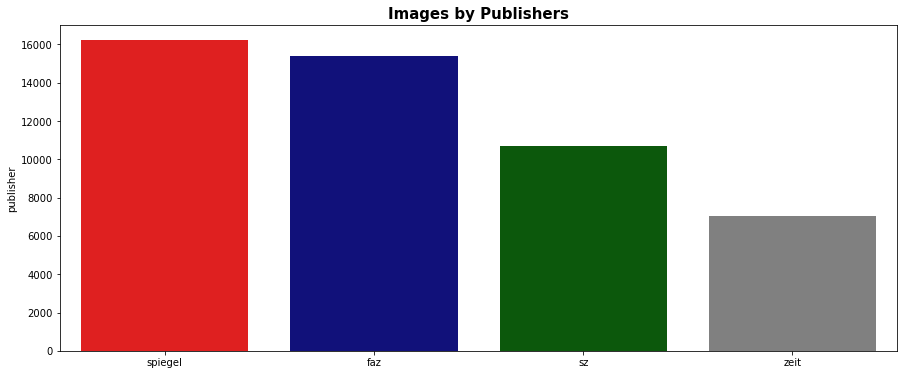

In [58]:
plt.figure(figsize=(15,6))
plt.title('Images by Publishers', fontsize=15, fontweight='bold')
sns.barplot(df_all.publisher.value_counts().index,df_all.publisher.value_counts(),palette=['red', 'darkblue', 'darkgreen', 'grey']);

/media/fabian/VM_space/anaconda3/envs/metis/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


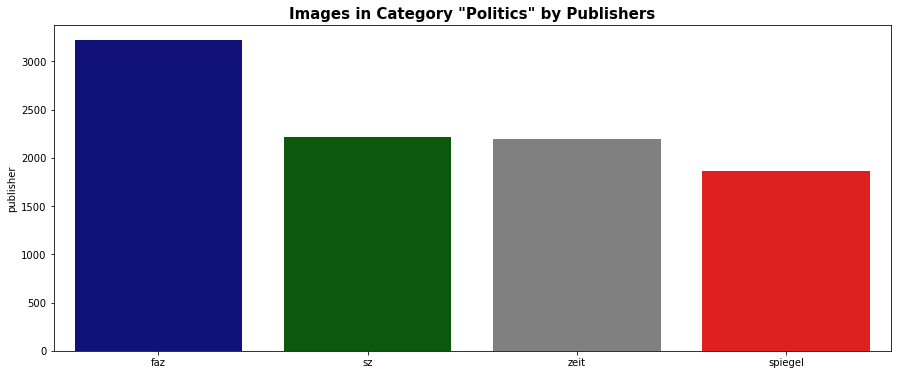

In [62]:
plt.figure(figsize=(15,6))
plt.title('Images in Category "Politics" by Publishers', fontsize=15, fontweight='bold')
sns.barplot(df_all.loc[(df_all['ressort'] == 'politik'), 'publisher'].value_counts().index,df_all.loc[(df_all['ressort'] == 'politik'), 'publisher'].value_counts(),palette=['darkblue', 'darkgreen', 'grey', 'red']);

/media/fabian/VM_space/anaconda3/envs/metis/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


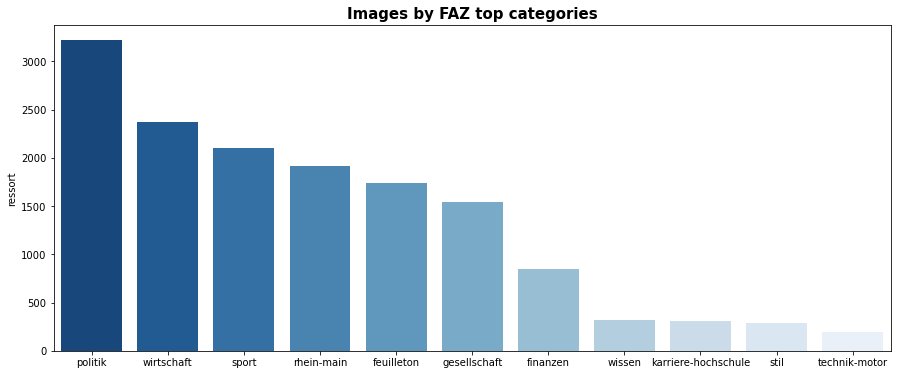

In [59]:
plt.figure(figsize=(15,6))
plt.title('Images by FAZ top categories', fontsize=15, fontweight='bold')
sns.barplot(df_faz_images.ressort.value_counts()[:11].index,df_faz_images.ressort.value_counts()[:11],palette='Blues_r');

/media/fabian/VM_space/anaconda3/envs/metis/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


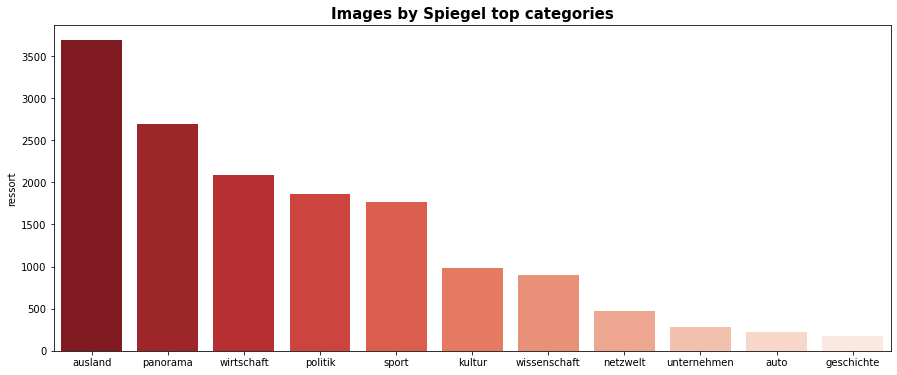

In [60]:
plt.figure(figsize=(15,6))
plt.title('Images by Spiegel top categories', fontsize=15, fontweight='bold')
sns.barplot(df_spiegel_images.ressort.value_counts()[:11].index,df_spiegel_images.ressort.value_counts()[:11],palette='Reds_r');

/media/fabian/VM_space/anaconda3/envs/metis/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


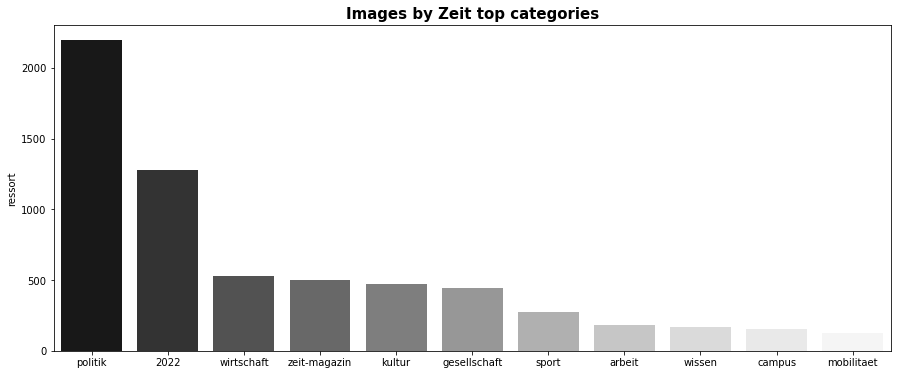

In [61]:
plt.figure(figsize=(15,6))
plt.title('Images by Zeit top categories', fontsize=15, fontweight='bold')
sns.barplot(df_zeit_images.ressort.value_counts()[:11].index,df_zeit_images.ressort.value_counts()[:11],palette='Greys_r');

/media/fabian/VM_space/anaconda3/envs/metis/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


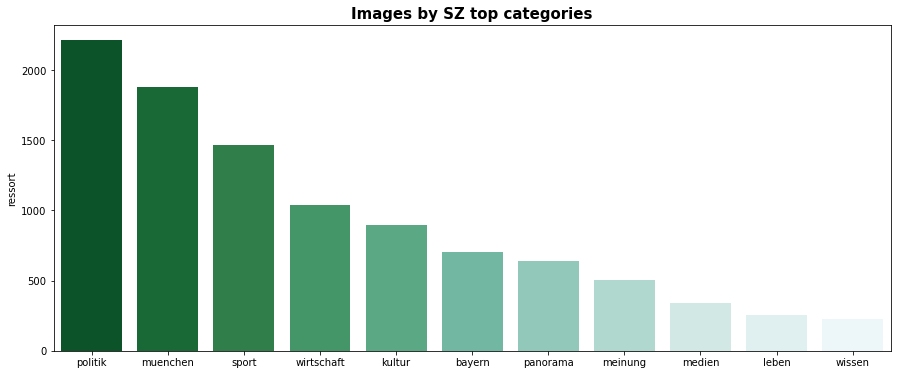

In [62]:
plt.figure(figsize=(15,6))
plt.title('Images by SZ top categories', fontsize=15, fontweight='bold')
sns.barplot(df_sz_images.ressort.value_counts()[:11].index,df_sz_images.ressort.value_counts()[:11],palette='BuGn_r');

Show image samples

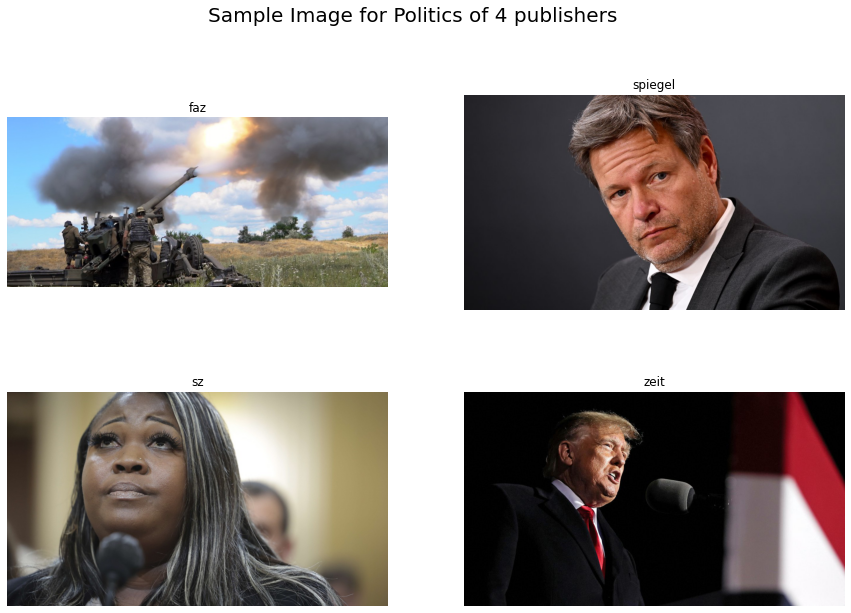

In [67]:
fig, ax = plt.subplots(2, 2,figsize= (15,10))
fig.suptitle('Sample Image for Politics of 4 publishers', fontsize=20)

for n,cate in enumerate(df_all[df_all['ressort']=='politik'].publisher.unique()):
    ax = plt.subplot(2,2,n+1)
    
    index = np.random.choice(df_all.loc[(df_all['ressort']=='politik') & 
                         (df_all['publisher']==cate), 'image_path'])
    try:
        img = mpimg.imread('project/work_data/test/' + index)
    except:
        try:
            img = mpimg.imread('project/work_data/train/' + index)
        except:
            img = mpimg.imread('project/work_data/validation/' + index)
        
    plt.imshow(img)
    plt.title(cate)
    plt.axis('off')

## Dataset A - All Publishers

### Images

Separate Images to Train, Test and Validation Folders

In [ ]:
if os.path.exists('work_data') == False:
    work_path = os.getcwd()+"/project"
    original_dir = work_path +"/" + "publishers_image_dataset"

    cate = [cate for cate in os.listdir(original_dir)]

    work_dir = work_path +"/"+'work_data'
    os.mkdir(work_dir)

    train_dir = os.path.join(work_dir, 'train')
    os.mkdir(train_dir)
    validation_dir = os.path.join(work_dir, 'validation')
    os.mkdir(validation_dir)
    test_dir = os.path.join(work_dir, 'test')
    os.mkdir(test_dir)

    for x in ['train','validation','test']:
        up_dir = work_dir + "/" +x
        for y in cate:
            os.mkdir(os.path.join(up_dir,y))

    for x in cate:
        orginal_dir = original_dir +"/" + str(x)
        img_num =len([name for name in os.listdir(orginal_dir) if 'politik' in name])
        sep_n = int(img_num/5)
        
        file_list = []
        for filename in os.listdir(orginal_dir):
            filepath = os.path.join(orginal_dir, filename)
            if os.path.isfile(filepath):
                if 'politik' in filename:
                    file_list.append(filename)
        
#         file_list = os.listdir(orginal_dir)     
        
        test_dir = work_dir + "/" + "test"+ "/" + x
        val_dir = work_dir + "/" + "validation"+ "/" + x
        train_dir = work_dir + "/" + "train"+ "/" + x
        for file in file_list[:sep_n]:
            src = os.path.join(orginal_dir, file)
            dst = os.path.join(test_dir, file)
            shutil.copyfile(src, dst)
        for file in file_list[sep_n:2*sep_n]:
            src = os.path.join(orginal_dir, file)
            dst = os.path.join(val_dir, file)
            shutil.copyfile(src, dst)    
        for file in file_list[2*sep_n:img_num]:
            src = os.path.join(orginal_dir, file)
            dst = os.path.join(train_dir, file)
            shutil.copyfile(src, dst)

Convert Images to Numerical Arrays

In [68]:
def img_to_array(img_path):
    img=  IMG.load_img(img_path,target_size=[150,150])
    x = IMG.img_to_array(img)
    return x

In [69]:
filepath = os.getcwd()+'/project/work_data'

work_data_df = {'image_path':[],'category':[],'class':[]}

for class_ in os.listdir(filepath): 
    for category in os.listdir(filepath +"/"+class_):      
        for image in os.listdir(filepath +"/"+class_ +"/"+category):
            work_data_df['image_path'].append(filepath +"/"+class_+"/"+category+"/"+ image)
            work_data_df['category'].append(category)
            work_data_df['class'].append(class_)
work_data_df = pd.DataFrame(work_data_df)    
work_data_df.head()

,image_path,category,class
0,/media/fabian/VM_space/Metis/06_DeepL/project/...,images_spiegel,validation
1,/media/fabian/VM_space/Metis/06_DeepL/project/...,images_spiegel,validation
2,/media/fabian/VM_space/Metis/06_DeepL/project/...,images_spiegel,validation
3,/media/fabian/VM_space/Metis/06_DeepL/project/...,images_spiegel,validation
4,/media/fabian/VM_space/Metis/06_DeepL/project/...,images_spiegel,validation


In [70]:
# work_data_df.to_csv('work_data_df')

In [71]:
X_train = []
X_val = []
X_test = []

data_train = work_data_df[work_data_df['class'] == 'train']
y_train = data_train.category.astype("category").cat.codes
y_train_hotcode = keras.utils.to_categorical(y_train)
for index in data_train.index:
    X_train.append(img_to_array(data_train.loc[index,'image_path']))
    
data_val = work_data_df[work_data_df['class'] == 'validation']
y_val = data_val.category.astype("category").cat.codes
y_val_hotcode = keras.utils.to_categorical(y_train)
for index in data_val.index:
    X_val.append(img_to_array(data_val.loc[index,'image_path']))    
    
data_test = work_data_df[work_data_df['class'] == 'test']
y_test = data_test.category.astype("category").cat.codes
y_test_hotcode = keras.utils.to_categorical(y_test)
for index in data_test.index:
    X_test.append(img_to_array((data_test.loc[index,'image_path'])))   
    
X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

In [72]:
### Save X_digit, y_digit
# image_data_array = (X_train, X_test,X_val,y_train,y_test,y_val)
# with open('image_data_array.pickle','wb') as file:
#     pickle.dump(image_data_array,file)

In [73]:
print(f"We have {len(X_train)} train dataset")
print(f"We have {len(X_val)} val dataset")
print(f"We have {len(X_test)} test dataset")

We have 5707 train dataset
We have 1902 val dataset
We have 1902 test dataset


In [74]:
global category_map
category_int_map = dict(zip(data_train.category,y_train))
int_category_map = dict(zip(y_train,data_train.category))
int_category_map

{1: 'images_spiegel', 3: 'images_zeit', 0: 'images_faz', 2: 'images_sz'}

In [75]:
category_int_map

{'images_spiegel': 1, 'images_zeit': 3, 'images_faz': 0, 'images_sz': 2}

## Dataset B - FAZ (mid-right) and Spiegel (mid-left) (Binary classification)

### Images

In [ ]:
if os.path.exists('work_data_fazspiegel') == False:
    work_path = os.getcwd()+"/project"
    original_dir = work_path +"/" + "publishers_image_dataset"

    cate = [cate for cate in os.listdir(original_dir)][::2]

    work_dir = work_path +"/"+'work_data_fazspiegel'
    os.mkdir(work_dir)

    train_dir = os.path.join(work_dir, 'train')
    os.mkdir(train_dir)
    validation_dir = os.path.join(work_dir, 'validation')
    os.mkdir(validation_dir)
    test_dir = os.path.join(work_dir, 'test')
    os.mkdir(test_dir)

    for x in ['train','validation','test']:
        up_dir = work_dir + "/" +x
        for y in cate:
            os.mkdir(os.path.join(up_dir,y))

    for x in cate:
        orginal_dir = original_dir +"/" + str(x)
        img_num =len([name for name in os.listdir(orginal_dir) if ('politik' in name) and (('spiegel' in name) or ('faz' in name))])
        sep_n = int(img_num/5)
        
        file_list = []
        for filename in os.listdir(orginal_dir):
            filepath = os.path.join(orginal_dir, filename)
            if os.path.isfile(filepath):
                if ('politik' in filename) and (('spiegel' in filename) or ('faz' in filename)):
                    file_list.append(filename)  
        
        test_dir = work_dir + "/" + "test"+ "/" + x
        val_dir = work_dir + "/" + "validation"+ "/" + x
        train_dir = work_dir + "/" + "train"+ "/" + x
        for file in file_list[:sep_n]:
            src = os.path.join(orginal_dir, file)
            dst = os.path.join(test_dir, file)
            shutil.copyfile(src, dst)
        for file in file_list[sep_n:2*sep_n]:
            src = os.path.join(orginal_dir, file)
            dst = os.path.join(val_dir, file)
            shutil.copyfile(src, dst)    
        for file in file_list[2*sep_n:img_num]:
            src = os.path.join(orginal_dir, file)
            dst = os.path.join(train_dir, file)
            shutil.copyfile(src, dst)  

In [4]:
filepath = os.getcwd()+'/project/work_data_fazspiegel'

work_data_df = {'image_path':[],'category':[],'class':[]}

for class_ in os.listdir(filepath): 
    for category in os.listdir(filepath +"/"+class_):      
        for image in os.listdir(filepath +"/"+class_ +"/"+category):
            work_data_df['image_path'].append(filepath +"/"+class_+"/"+category+"/"+ image)
            work_data_df['category'].append(category)
            work_data_df['class'].append(class_)
work_data_df = pd.DataFrame(work_data_df)    
work_data_df.head()

,image_path,category,class
0,/media/fabian/VM_space/Metis/06_DeepL/project/...,images_spiegel,validation
1,/media/fabian/VM_space/Metis/06_DeepL/project/...,images_spiegel,validation
2,/media/fabian/VM_space/Metis/06_DeepL/project/...,images_spiegel,validation
3,/media/fabian/VM_space/Metis/06_DeepL/project/...,images_spiegel,validation
4,/media/fabian/VM_space/Metis/06_DeepL/project/...,images_spiegel,validation


In [72]:
# work_data_df.to_csv('work_data_df_fazspiegel')

In [73]:
X_train = []
X_val = []
X_test = []

data_train = work_data_df[work_data_df['class'] == 'train']
y_train = data_train.category.astype("category").cat.codes
y_train_hotcode = keras.utils.to_categorical(y_train)
for index in data_train.index:
    X_train.append(img_to_array(data_train.loc[index,'image_path']))
    
data_val = work_data_df[work_data_df['class'] == 'validation']
y_val = data_val.category.astype("category").cat.codes
y_val_hotcode = keras.utils.to_categorical(y_train)
for index in data_val.index:
    X_val.append(img_to_array(data_val.loc[index,'image_path']))    
    
data_test = work_data_df[work_data_df['class'] == 'test']
y_test = data_test.category.astype("category").cat.codes
y_test_hotcode = keras.utils.to_categorical(y_test)
for index in data_test.index:
    X_test.append(img_to_array((data_test.loc[index,'image_path'])))   
    
X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

In [74]:
### Save X_digit, y_digit
image_data_array_fazsp = (X_train, X_test,X_val,y_train,y_test,y_val)
with open('image_data_array_fazsp.pickle','wb') as file:
    pickle.dump(image_data_array_fazsp,file)

In [75]:
print(f"We have {len(X_train)} train dataset")
print(f"We have {len(X_val)} val dataset")
print(f"We have {len(X_test)} test dataset")

We have 3063 train dataset
We have 1021 val dataset
We have 1021 test dataset


In [76]:
global category_map_fazsp
category_int_map_fazsp = dict(zip(data_train.category,y_train))
int_category_map_fazsp = dict(zip(y_train,data_train.category))
int_category_map_fazsp

{1: 'images_spiegel', 0: 'images_faz'}

In [77]:
category_int_map_fazsp

{'images_spiegel': 1, 'images_faz': 0}

In [7]:
work_data_df.loc[work_data_df['class'] == 'test', :].to_csv('work_data_df.csv')

## Dataset C - FAZ (mid-right) and Zeit (mid-left) (Binary classification)

### Teaser Text

In [93]:
df_faz_text = df_faz_images.loc[(df_faz_images['ressort'] == 'politik'), ['teaser', 'ressort']]
df_faz_text.drop(['ressort'], axis=1, inplace=True)
df_faz_text.loc[:, 'teaser'] = df_faz_text.teaser.str.replace('\t','')
df_faz_text.loc[:, 'teaser'] = df_faz_text.teaser.str.replace(' class="tsr-Base_Content">\n                                            ','')
df_faz_text.loc[:, 'teaser'] = df_faz_text.teaser.str.replace('\n                                        </div','')
df_faz_text.loc[:, 'teaser'] = df_faz_text.teaser.str.replace('</div','')
df_faz_text.loc[:, 'teaser'] = df_faz_text.teaser.str.replace('class="tsr-Base_Content">','')
df_faz_text.loc[:, 'teaser'] = df_faz_text.teaser.str.replace(' Ein Gastbeitrag.','')
df_faz_text.loc[:, 'publisher'] = 'faz'

df_zeit_text = df_zeit_images.loc[(df_zeit_images['ressort'] == 'politik'), ['teaser', 'ressort']]
df_zeit_text.drop(['ressort'], axis=1, inplace=True)
df_zeit_text = df_zeit_text[['teaser']]
df_zeit_text.loc[:, 'teaser'] = df_zeit_text.teaser.str[2:]
df_zeit_text.loc[:, 'teaser'] = df_zeit_text.teaser.str[:-2]
df_zeit_text.loc[:, 'teaser'] = df_zeit_text.teaser.str.replace(' \n','')
df_zeit_text.loc[:, 'publisher'] = 'zeit'


df_text = pd.concat([df_faz_text, df_zeit_text], axis=0)
df_text.dropna(inplace=True)
df_text.reset_index(drop=True, inplace=True)
df_text.drop_duplicates(inplace=True)

/tmp/ipykernel_10286/3480037257.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df_faz_text.loc[:, 'teaser'] = df_faz_text.teaser.str.replace(' Ein Gastbeitrag.','')


/media/fabian/VM_space/anaconda3/envs/metis/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


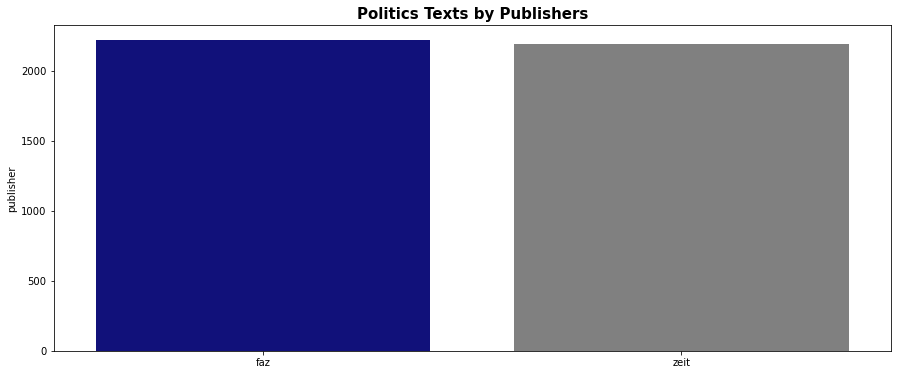

In [94]:
plt.figure(figsize=(15,6))
plt.title('Politics Texts by Publishers', fontsize=15, fontweight='bold')
sns.barplot(df_text.publisher.value_counts().index,df_text.publisher.value_counts(),palette=['darkblue', 'grey']);

In [95]:
df_text.to_csv('df_text.csv')

In [96]:
df_text

,teaser,publisher
0,Selenskyj skeptisch angesichts geplanter Verha...,faz
1,"Die SPD glaubt, sich ausreichend von Gerhard S...",faz
2,"Dauernd hieß es, China sei die größte Herausfo...",faz
3,"Der Krieg in der Ukraine wird zur Folge haben,...",faz
4,Der russische Überfall zeigt: Das Gas-Projekt ...,faz
...,...,...
4408,"NS-Opfer, die wegen ihrer sexuellen und geschl...",zeit
4409,Wegen steigender Mieten und Energiepreise soll...,zeit
4410,Für die Fahrer von Mähmaschinen sind Rehkitze ...,zeit
4411,Erdoğan hat es geschafft: Die Ukraine und Russ...,zeit
